In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as sts

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, distinct

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
#check columns in measurement table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine) 

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent = session.query(measurement.date).order_by(measurement.date.desc()).first()  
print(most_recent)


('2017-08-23',)


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
date = dt.datetime(2016, 8, 23)
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp).\
filter(measurement.date >= date).all()

Text(0.5, 1.0, '12-month Precipitation')

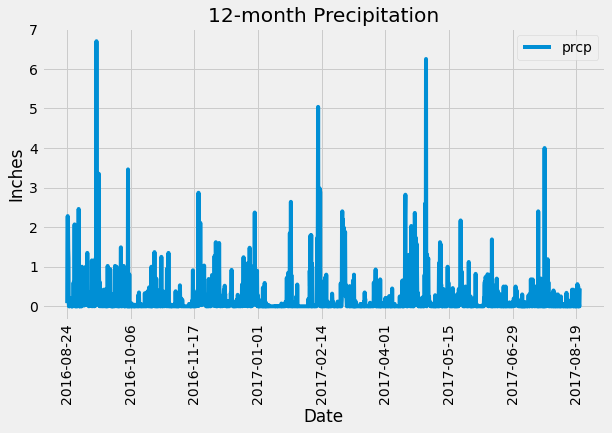

In [15]:
### Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data).set_index('date')
# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date').dropna()
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(rot=90, figsize=(9, 5))
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('12-month Precipitation')


In [16]:
p = precipitation_df['prcp'].dropna()
p

date
2016-08-24    0.08
2016-08-24    2.15
2016-08-24    2.28
2016-08-24    2.15
2016-08-24    1.45
              ... 
2017-08-22    0.00
2017-08-23    0.08
2017-08-23    0.00
2017-08-23    0.00
2017-08-23    0.45
Name: prcp, Length: 2015, dtype: float64

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
mean_numpy = np.mean(p)
print(f"The mean precipitation for the year of 8-23-2016 to 8-23-2017 is {mean_numpy}")

median_numpy = np.median(p)
print(f"The median precipitation for the year of 8-23-2016 to 8-23-2017 is {median_numpy}")

mode_scipy = sts.mode(p)
print(f"The mode precipitation for the year of 8-23-2016 to 8-23-2017 is {mode_scipy}")

var_numpy = np.var(p,ddof = 0)
print(f"The precipitation variance for the year of 8-23-2016 to 8-23-2017 is {var_numpy}")

sd_numpy = np.std(p,ddof = 0)
print(f"The precipitation standard deviation using the NumPy module is {sd_numpy}") 

quartiles = p.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of precipitation is: {lowerq}")
print(f"The upper quartile of precipitation is: {upperq}")
print(f"The interquartile range of precipitation is: {iqr}")
print(f"The the median of precipitation is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The mean precipitation for the year of 8-23-2016 to 8-23-2017 is 0.17646153846153778
The median precipitation for the year of 8-23-2016 to 8-23-2017 is 0.02
The mode precipitation for the year of 8-23-2016 to 8-23-2017 is ModeResult(mode=array([0.]), count=array([873]))
The precipitation variance for the year of 8-23-2016 to 8-23-2017 is 0.21176023363236773
The precipitation standard deviation using the NumPy module is 0.4601741340322897
The lower quartile of precipitation is: 0.0
The upper quartile of precipitation is: 0.13
The interquartile range of precipitation is: 0.13
The the median of precipitation is: 0.02 
Values below -0.195 could be outliers.
Values above 0.325 could be outliers.


In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number stations in the dataset (Stu_Reflection.ipynb)
stations = session.query(measurement).group_by(measurement.station).count()
print(stations)

9


In [21]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
#most_active = session.query(measurement.)
sel = [measurement.station,
      func.count(measurement.station)]

active_stations = session.query(*sel).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station)).all()

# List the stations and the counts in descending order.
active_stations

[('USC00518838', 511),
 ('USC00517948', 1372),
 ('USC00511918', 1979),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00519523', 2669),
 ('USC00513117', 2709),
 ('USC00519397', 2724),
 ('USC00519281', 2772)]

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_sel = [measurement.station,
               func.min(measurement.tobs),
               func.max(measurement.tobs),
               func.avg(measurement.tobs),
               func.count(measurement.tobs)
              ]

most_active = session.query(*station_sel).\
    filter(measurement.station == 'USC00519281').all()
most_active

[('USC00519281', 54.0, 85.0, 71.66378066378067, 2772)]

In [39]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#query last date from most active station : USC00519281
date_sel = [measurement.station,
                 measurement.date]
last_date = session.query(*date_sel).\
    filter(measurement.station == 'USC00519281').\
    order_by(measurement.date.desc()).first()
last_date 

# Calculate the date one year from the last date in data set for most active station : USC00519281
year_date = dt.datetime(2016, 8, 18)

# Perform a query to retrieve the data and temperature measurements for most active station : USC00519281
temperature_data = session.query(measurement.date, measurement.tobs).\
filter(measurement.station == 'USC00519281').\
filter(measurement.date > year_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
temperature_df = pd.DataFrame(temperature_data).set_index('date')
# Sort the dataframe by date
temperature_df = temperature_df.sort_values(by='date').dropna()
temperature_df

,tobs
date,
2016-08-19,79.0
2016-08-20,81.0
2016-08-21,79.0
2016-08-22,78.0
2016-08-23,77.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


Text(0.5, 0, 'Temperature')

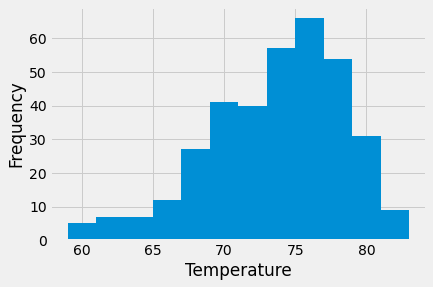

In [46]:
# Use Pandas Plotting with Matplotlib to plot the data
temperature_df['tobs'].plot(kind='hist', bins=12)
plt.xlabel('Temperature')

# Close session

In [47]:
# Close Session
session.close()